In [27]:
# OpenAI Gym
import gym_tetris as gym
import gym.spaces
import numpy as np
import keras

# Rendering tools
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from IPython.display import clear_output
import cv2

In [28]:
env = gym.make('Tetris-v0')
downsize = (10,20)
observation=env.reset()

In [29]:
def resize(img,downsize):
    resized = cv2.resize(img,
                         dsize=downsize,
                         interpolation=cv2.INTER_CUBIC)
    return resized

In [30]:
resized_observation = resize(observation[17:423,7:212],downsize)
in_size = resized_observation.shape
obs_size = resized_observation.size
action_space = 6
display(in_size)
display(obs_size)

(20, 10, 3)

600

In [31]:
#NEW FUNCTION
#BW: black/white--removes colors
def BW(downsized_image):
    board = np.arange(200).reshape(20,10)
    for i in range (in_size[0]):
        for j in range (in_size[1]):
            board[i,j] = -1
            for k in range (in_size[2]):
                if downsized_image[i][j][k] > 0:
                    board[i,j] = 1
    return board

In [32]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, concatenate, Lambda
from keras.models import Model

In [33]:
def make_model(state, action_size):
    MainInput = Input(shape=(20,10,1))
    Column = Conv2D(64, kernel_size=(20, 1), activation='relu',input_shape=[20,10,1])(MainInput)
    Col_Flat = Flatten()(Column)
    Col_Out = Dense(20, activation='relu')(Col_Flat)
    Row = Conv2D(64, kernel_size=(10, 1), activation='relu',input_shape=[20,10,1])(MainInput)
    Row_Flat = Flatten()(Row)
    Row_Out = Dense(20, activation='relu')(Row_Flat)
    Contours1 = Conv2D(64, (5, 5), activation='relu')(MainInput)
#    Contours2 = MaxPooling2D(pool_size=(2, 2))(Contours1)
    Contours2 = Conv2D(64, (3, 3), activation='relu')(Contours1)
    Contours3 = Conv2D(64, (1, 1), activation='relu')(Contours2)
    Contours4 = Conv2D(64, (3, 3), activation='relu')(Contours3)
    Contours5 = MaxPooling2D(pool_size=(1, 1))(Contours4)
    Contours6 = Flatten()(Contours5)
    Contours_Out = Dense(20, activation='relu')(Contours6)
    Final1 = concatenate(axis=1,inputs=([Contours_Out,Row_Out,Col_Out]))
    Final2 = Dense(90, activation='relu')(Final1)
    Final3 = Dropout(0.2)(Final2)
    Final4 = Dense(30, activation='relu')(Final3)   
    SelectAction = Dense(action_size, activation='linear')(Final4)
    Q = Lambda(lambda x: x+1)(SelectAction)
    model = Model(MainInput,SelectAction)
    model.compile(loss='mse',optimizer=keras.optimizers.Adam(lr=0.0003))
    return model

model = make_model(BW( resize(observation,downsize) ),action_space) #CHANGED
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 20, 10, 1)    0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 16, 6, 64)    1664        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 14, 4, 64)    36928       conv2d_15[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 14, 4, 64)    4160        conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_18 

In [34]:
from IPython.display import SVG
from IPython.display import display
from keras.utils.vis_utils import model_to_dot

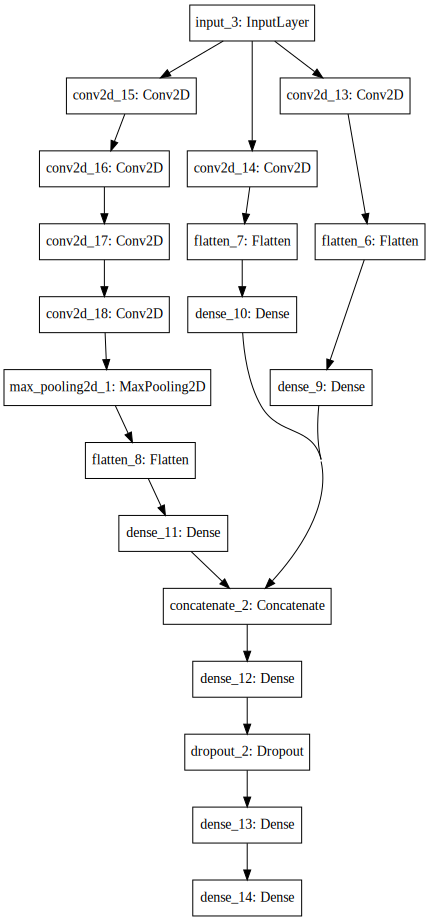

In [35]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [36]:
class ReplayMemory:
    #default constructor
    def __init__(self, memory_size, state_size, action_size):
#        self.state_size = [state_size.shape[0], state_size.shape[1]] #dimensions of tetris board: [20,10]
        self.state_size = state_size #flattened tetris board: 200
        self.action_size = action_size #number of possible actions: 6
        self.size = 0
        self.maxsize = memory_size #number of states to remember: 500000
        self.current_index = 0 #current remembered state being looked at
        self.current_state = np.zeros([memory_size, state_size])
        self.action = [0]*memory_size # Remember, actions are integers... (create action array of size 500,000 and initialize all actions to zero)
        self.reward = np.zeros([memory_size]) #create reward array of size 500,000 and initialize all to zero
        self.next_state = np.zeros([memory_size, state_size])
        self.done = [False]*memory_size # Boolean (terminal transition?)
        
    def remember(self, current_state, action, reward, next_state, done):
        # Stores a single memory item
        self.current_state[self.current_index,:] = current_state
        self.action[self.current_index] = action
        self.reward[self.current_index] = reward
        self.next_state[self.current_index,:] = next_state
        self.done[self.current_index] = done
        self.current_index = (self.current_index+1)%self.maxsize
        self.size = max(self.current_index,self.size)
    
    def replay(self, model, target_model, num_samples, sample_size, gamma):
        # Run replay!
        
        # Can't train if we don't yet have enough samples to begin with...
        if self.size < sample_size:
            return
        
        for i in range(num_samples):
            # Select sample_size memory indices from the whole set
            current_sample = np.random.choice(self.size,sample_size,replace=False) #select subarray of memorized positions
            
            # Slice memory into training sample
            current_state1 = self.current_state[current_sample,:]
            current_state2 = current_state1.reshape(current_sample.size,20,10)
            action = [self.action[j] for j in current_sample]
            reward = self.reward[current_sample]
            next_state1 = self.next_state[current_sample,:]
            next_state2 = next_state1.reshape(current_sample.size,20,10)
            done = [self.done[j] for j in current_sample]
#            if current_state.size == obs_size:
            model_targets = model.predict(np.expand_dims(current_state2,axis=3))
                # Create targets from argmax(Q(s+1,a+1))
                # Use the target model!
                #print(next_state.size)
            targets = reward + gamma*np.amax(target_model.predict(np.expand_dims(next_state2,axis=3)),axis=1)

                # Absorb the reward on terminal state-action transitions
            targets[done] = reward[done]
                # Update just the relevant parts of the model_target vector...
            model_targets[range(sample_size),action] = targets

                # Update the weights accordingly
            model.fit(np.expand_dims(current_state2,axis=3),model_targets,
                epochs=1,verbose=0,batch_size=sample_size)

        # Once we have finished training, update the target model
        target_model.set_weights(model.get_weights())

In [38]:
from collections import deque

# Hyperparameters
gamma = 0.99
epsilon = 1.0
epsilon2 = 0.2
epsilon_decay = 0.99
epsilon_min = 0.0001
episodes = 20000

replay_iterations = 100
replay_sample_size = 100

# Peformance stats
times_window = deque(maxlen=100)
mean_times = deque(maxlen=episodes)
rewards = deque(maxlen=episodes)
epsilons = deque(maxlen=episodes)

# Initialize the environment and agent data structures
env = gym.make('Tetris-v0')
observation = env.reset()
resized_obs = BW(resize(observation[17:423,7:212],downsize))
model = make_model(resized_obs, action_space)
target_model = make_model(resized_obs, action_space)
memory = ReplayMemory(500000, 200, action_space)

In [14]:
model.load_weights('model.h5')

In [18]:
#Run this when display surface quit
env = gym.make('Tetris-v0')
observation = env.reset()

In [ ]:
model.save_weights('weights.h5')

In [ ]:
done = False
cleared_total = 0
# Perform the training!
for episode in range(episodes):
    current_state = env.reset()
    current_state = current_state[17:423,7:212]
    board = BW(resize(current_state, downsize))
    time = 0
    total_reward = 0.0
    total_Q = 0
    max_Q=0
    min_Q=0
    height=0
    total_score = 0.0
    cleared=0
    Totalholes=0
    while not done:
        time += 1
        Q = model.predict(np.expand_dims(np.expand_dims(board, axis=0), axis=3))  # Compute Q
        maxQ=0
        next_state, reward, done, info = env.step(action) # take action!
        next_height=info['height']
        #REWARD SHAPING
        if next_height > 15:
            done=True
        elif height < next_height and next_height > 4:
            reward-=0.1*pow((next_height-height),2)
            height=next_height
        elif next_height < height:
            reward+=15*pow((height-next_height),3)
            cleared+=height-next_height
            cleared_total+=cleared
            height=next_height
        elif next_height == height:
            reward+=0.005
        total_score+=info['score']
        #punish for holes in tower
        if height < next_height:
            for i in range(15,20):
                fullness = 0
                emptiness = 0
                for j in range(0,10):
                    if board[i,j] == 1:
                        fullness+=1
                    else:
                        emptiness+=1
                if next_height <= 5:
                    reward+=0.00003*i*fullness
                else:
                    reward-=0.00001*i*emptiness
        if done:
            reward -= 25.0
        reward += 0.02
        total_reward += reward
        curr_Q = Q[0][action]-maxQ
        if curr_Q > max_Q:
            max_Q = curr_Q
        elif not done and curr_Q < min_Q:
            min_Q = curr_Q
        total_Q += curr_Q
        next_state = next_state[17:423,7:212]
        resize_Next_state = BW(resize(next_state,downsize)) #CHANGED
        memory.remember(board.reshape(200), action,reward,resize_Next_state.reshape(200),done) # Store in memory...

        current_state = next_state # Transition to next state!
        board = BW(resize(current_state, downsize))
        if (done):
            break
    epsilon = epsilon * epsilon_decay if epsilon > epsilon_min else epsilon_min 
    times_window.append(time)
    mean_time = np.mean(times_window)
    mean_times.append(mean_time)
    epsilons.append(epsilon)
    print('\rEpisode %d/%d - time: %d, mean-time: %d, epsilon: %f, reward: %g, Max Q: %g, Min Q: %g, Cleared: %d'%(episode+1,
                                                                                                                                 episodes,
                                                                                                                                 time,
                                                                                                                                 mean_time,
                                                                                                                                 epsilon,
                                                                                                                                 total_reward,
                                                                                                                                 max_Q,
                                                                                                                                 min_Q,
                                                                                                                                 cleared),end='')
    print(' cleared total:',cleared_total)
    done = False
    
    # Training...
    memory.replay(model,target_model,replay_iterations,replay_sample_size,gamma)
print()

In [ ]:
plt.plot(times_window)
plt.title("Tetris Q-Learning Performance")
plt.xlabel("Episode Number")
plt.ylabel("Life Span")
plt.show()

In [ ]:
# Test out the agent!
# Initialize the environment and let the agent decide how to act!
env = gym.make('Tetris-v0')
observation = env.reset()
done = False
time = 0
reward = 0.0
while not done:
    observation2 = observation[17:423,7:212]
    obs = resize(observation,downsize)
    plt.imshow(observation)
    plt.title("%s | Time: %d | Reward: %f" % (env.spec.id, time, reward))
    clear_output(wait=True)
    Q = model.predict(np.expand_dims(np.expand_dims(BW(obs),axis=0),axis=3))
    action = np.argmax(Q)
    print(Q,"\n")
    print(action)
    #action = np.random.choice(action_space)# if np.random.random() < epsilon else np.argmax(Q)    
    observation, reward, done, info = env.step(action)
    height = info['height']
    print(' ',height)
    if (done):
        break
    time+=1
clear_output(wait=True)

In [ ]:
plt.plot(result_times)
plt.title("Tetris Q-Learning Performance")
plt.xlabel("Episode Number")
plt.ylabel("Life Span")
plt.show()

In [249]:
model.save_weights("model.h5")